C:\Users\lhille\AppData\Local\Temp\ipykernel_35212\3136710696.py:30: RuntimeWarning: divide by zero encountered in log10
  HyMAG = np.log10(np.abs(Hy))


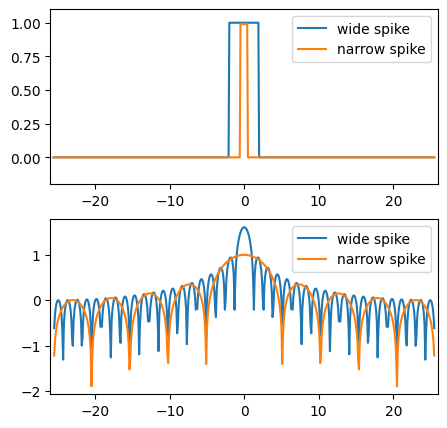

In [37]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def calculate_ft(input):
    return np.fft.fftshift(np.fft.fft(np.fft.ifftshift(input)))

def calculate_ift(input):
    return np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(input)))

# Parameters
sizeS = 512
dS=0.1
x=np.arange(-(sizeS/2)*dS,(sizeS/2)*dS,dS,dtype=float)

# Initialize y with small values
y = np.zeros((2, sizeS)) + 1e-15

# Set values for the spikes
y[0, np.abs(x) < 2.0] = 1.0
y[1, np.abs(x) < 0.5] = 0.99

# Compute the FFT
Hy = np.zeros((2, sizeS), dtype=complex)
Hy[0, :] = calculate_ft(y[0, :])
Hy[1, :] = calculate_ft(y[1, :])
#Hy[:,0] = Hy[:,1]

# Compute the magnitude in log scale
HyMAG = np.log10(np.abs(Hy))

# Plot the spikes
fig,ax=plt.subplots(2,1,figsize=(5,5))
ax0=ax[0]
ax1=ax[1]
for i,nn in enumerate(['wide spike','narrow spike']):
    ax0.plot(x, y[i], label=nn)
    ax1.plot(x, HyMAG[i], label=nn)
    ax[i].set_xlim(int(.99+(sizeS/2)*dS) * np.array([-1,1]))

ax0.set_ylim([-0.2, 1.1])
ax0.legend()
ax1.legend()



In [35]:
np.where(abs(Hy[0,:])==0)

(array([  0,  64, 128, 192, 320, 384, 448], dtype=int64),)

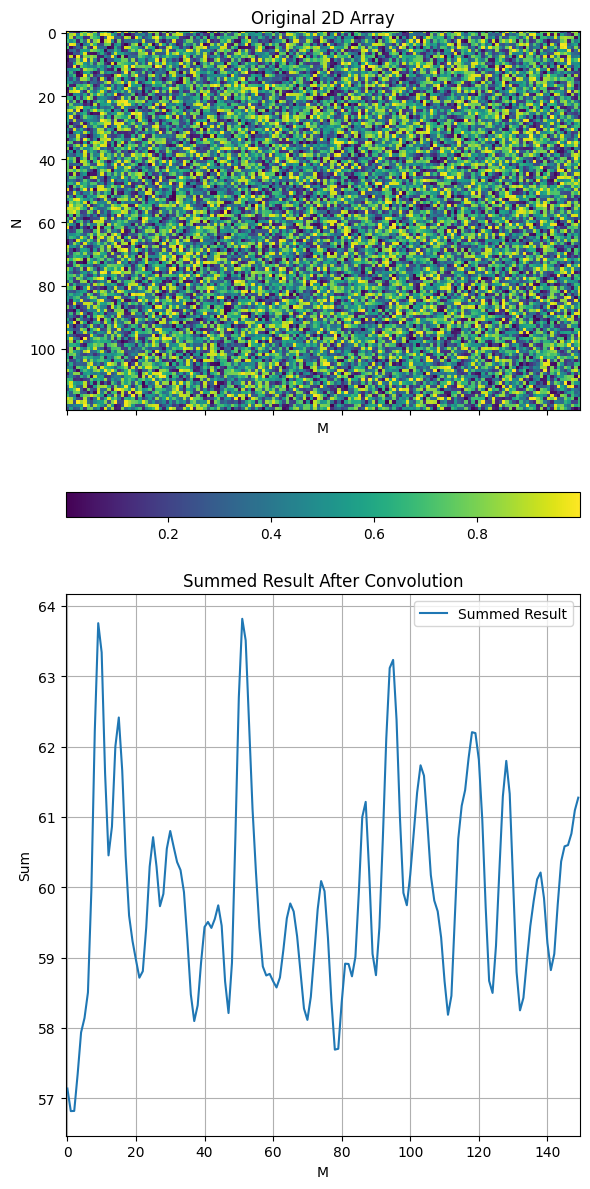

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d

# Parameters
sigma = 1.0  # Standard deviation of the Gaussian kernel
kernel_size = 10  # Size of the Gaussian kernel
M, N = 150, 120  # Dimensions of the 2D array

# Generate the Gaussian 1D kernel
x = np.linspace(-3*sigma, 3*sigma, kernel_size)
gaussian_kernel = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-x**2 / (2 * sigma**2))

# Normalize the kernel
gaussian_kernel /= np.sum(gaussian_kernel)

# Generate a random 2D array
array_2d = np.random.rand(M, N)

# Convolve the 1D kernel with each column of the 2D array along the M axis
convolved_array = np.zeros_like(array_2d)
for n in range(N):
    convolved_array[:, n] = convolve1d(array_2d[:, n], gaussian_kernel, mode='reflect')

# Sum across the N dimension
result = np.sum(convolved_array, axis=1)

fig,ax=plt.subplots(2,1,figsize=(6,12),sharex=True)
ax0=ax[0]
ax1=ax[1]

cset1=ax0.imshow(array_2d.transpose(), aspect='auto', cmap='viridis')
ax0.set_title('Original 2D Array')
ax0.set_xlabel('M')
ax0.set_ylabel('N')
plt.colorbar(cset1,ax=ax0,location='bottom')


# Plot the summed result
#plt.subplot(2, 1, 2)
ax1.plot(result, label='Summed Result')
ax1.set_title('Summed Result After Convolution')
ax1.set_xlabel('M')
ax1.set_ylabel('Sum')
ax1.legend()
ax1.grid(True)
fig.tight_layout()




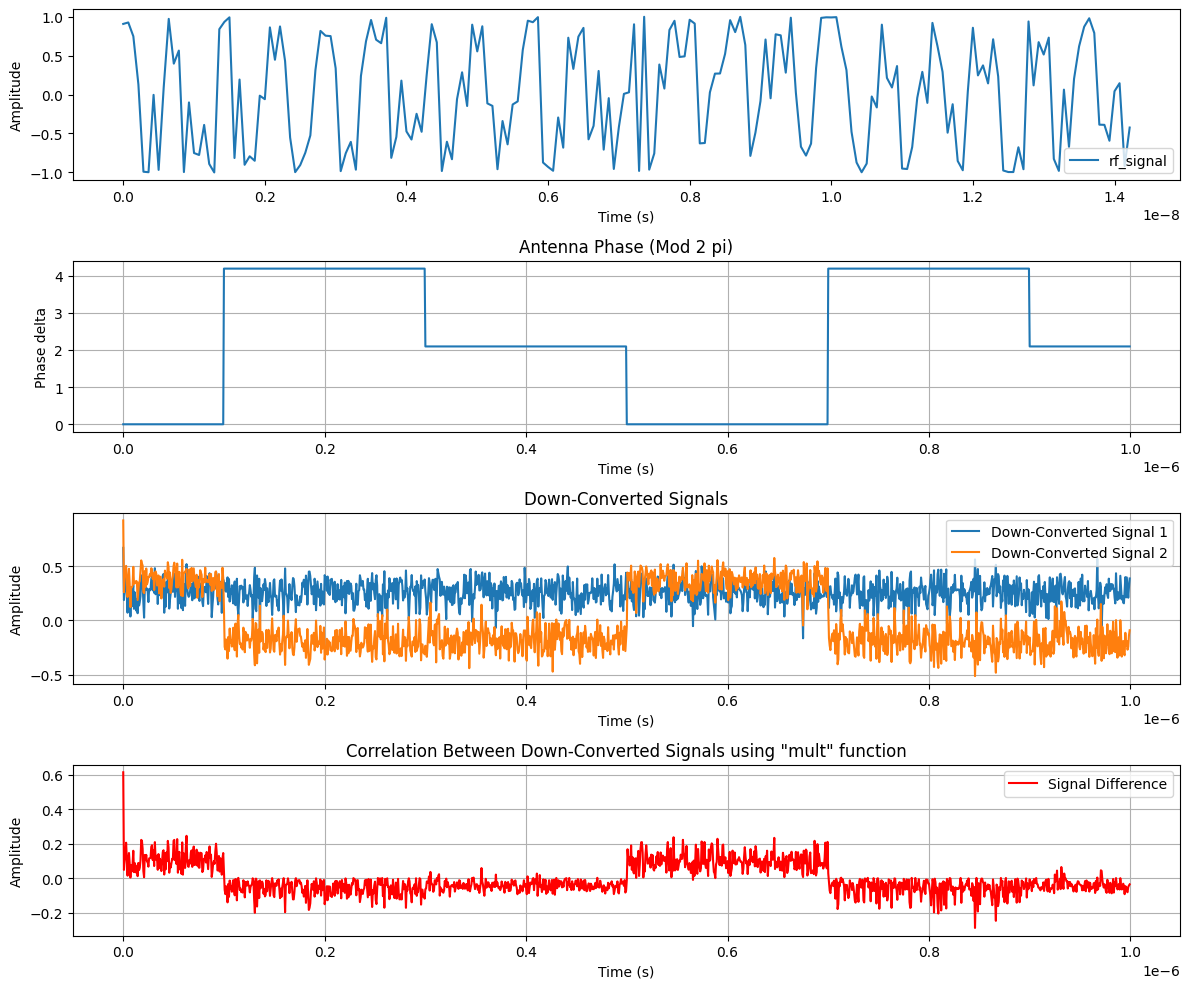

In [165]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# Constants
c = 3e8  # Speed of light in m/s
f_rf = 1.4e9  # RF frequency in Hz (1 GHz)
f_if = 2e6  # IF sample rate in Hz (2 MHz)

cutoff_freq = f_if / 2  # Cutoff frequency for the low-pass filter (1 MHz)


lambda_rf = c / f_rf  # Wavelength of the RF signal
f_lo = f_rf  # LO frequency, same as RF frequency for simplicity

# Parameters
D1 = 100  # Distance to antenna 1 in meters
D2 = 120  # Distance to antenna 2 in meters
PHo = np.pi / 4  # Average phase offset in radians
Nph1 = 0.0010  # Phase noise for antenna 1 in radians
Nph2 = 0.002  # Phase noise for antenna 2 in radians

# Time vector
fs = 10 * f_rf  # Sampling frequency (10 times the RF frequency for oversampling)
decimation_rate = int(fs / f_if)  # Decimation rate

t = np.arange(0, 1e-6, 1/fs)  # 1 microsecond duration

# RF source signal (assuming a simple sinusoidal signal)
rf_ph = 0.8 # Phase noise for antenna 1 in radians
rf_signal = np.cos(2 * np.pi * f_rf * t + rf_ph * np.random.randn(len(t)))


# Phase delays due to distance

#how many discrete steps to take between phase_delay1 and phase_delay2
phaseSteps=5
phase_delay1 = 0
if phaseSteps>0:
    phase_delay2 = 2 * np.pi * (((D2-D1)*np.round(np.linspace(0,phaseSteps,len(t)))/phaseSteps) / lambda_rf)
else:
    phase_delay2 = 2 * np.pi * ((D2-D1) / lambda_rf)


# LO signals with phase offsets and noise
lo1 = np.cos(2 * np.pi * f_lo * t + phase_delay1 + PHo + Nph1 * np.random.randn(len(t)))
lo2 = np.cos(2 * np.pi * f_lo * t + phase_delay2 + Nph2 * np.random.randn(len(t)))

# Mixing (down-conversion)
mixed_signal1 = rf_signal * lo1
mixed_signal2 = rf_signal * lo2

# Low-pass filter design
def lowpass_filter(signal, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

# Filter the mixed signals
cutoff = f_rf / 2  # Cutoff frequency for the low-pass filter
filtered_signal1 = lowpass_filter(mixed_signal1, cutoff, fs)
filtered_signal2 = lowpass_filter(mixed_signal2, cutoff, fs)


# Decimation (downsampling)
decimated_signal1 = filtered_signal1[::decimation_factor]
decimated_signal2 = filtered_signal2[::decimation_factor]

# Time vector for decimated signals
t_decimated = t[::decimation_factor]

# Correl between down-converted signals
signal_assessment_type='mult'

if signal_assessment_type == 'mult':
    signal_assessment = decimated_signal1 * decimated_signal2 
elif signal_assessment_type == 'diff':
    signal_assessment = decimated_signal1 - decimated_signal2




# Plotting the signals
plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(t[:200], rf_signal[:200], label='rf_signal')
plt.title('Emitted Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(t_decimated, phase_delay2[::decimation_factor]% (2*np.pi) if phaseSteps > 0 else [phase_delay2 % (2*np.pi)]*len(t_decimated), label='Down-Converted Signal 1')
plt.title('Antenna Phase (Mod 2 pi)')
plt.xlabel('Time (s)')
plt.ylabel('Phase delta')
plt.grid(True)


plt.subplot(4, 1, 3)
plt.plot(t_decimated, decimated_signal1, label='Down-Converted Signal 1')
plt.plot(t_decimated, decimated_signal2, label='Down-Converted Signal 2')
plt.title('Down-Converted Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t_decimated, signal_assessment, label='Signal Difference', color='red')
plt.title(f'Correlation Between Down-Converted Signals using "{signal_assessment_type}" function')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

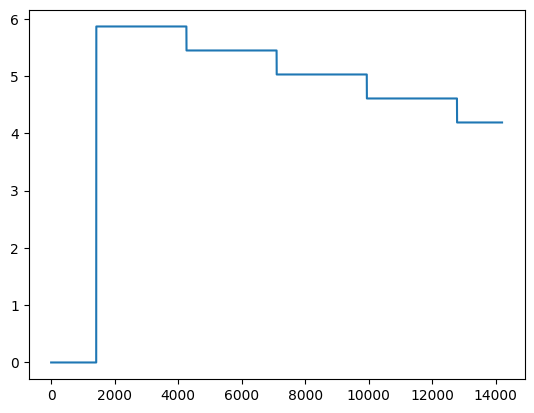

In [142]:
plt.plot(phase_delay2 % (2*np.pi))
#plt.plot(phase_delay2,'r')